# Data Preparation 

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler

**Hybrid preprocessing for vision**

compare a tiny variational feature map (≤4 qubits on a simulator or IBM device) against a classical baseline on a toy dataset; treat it as a learning exercise in data encoding, noise, and cost models rather than “quantum beats classical.”

In [2]:
transform = transforms.Compose([          #chains multiple transformations 
    transforms.Resize((8,8)),    #downsampling  from 28x28 -> 8x8 so features stay small -64
    transforms.ToTensor(),     #transforms data to tensor
])

train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)     #60000 labeled images
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)     #10000 labeled images 

#because we are filtering the MNIST dataset for only 0/1s not 0-9
train_idx = (train_dataset.targets==0) | (train_dataset.targets==1)
test_idx = (test_dataset.targets==0) | (test_dataset.targets==1)


X_train = train_dataset.data[train_idx].float() / 255.0  #normalizes to [0,1]   
y_train = train_dataset.targets[train_idx]     
X_test = test_dataset.data[test_idx].float() / 255.0
y_test = test_dataset.targets[test_idx]  

print("\nExample vector: ", X_train[0])  



Example vector:  tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.00

#### Flatten Images
multidimensonal images take up more space than a big 1d array, reduces time to run model

In [3]:
X_train_flat = X_train.view(X_train.shape[0], -1)  #shape is now (N_sampels, 64)  
X_test_flat = X_test.view(X_test.shape[0], -1)   

print("flattened shape xtrain: ", X_train_flat.shape)
print("flattened shape xtest: ", X_train_flat.shape)

print("\nExample vector: ", X_train_flat[0])  


flattened shape xtrain:  torch.Size([12665, 784])
flattened shape xtest:  torch.Size([12665, 784])

Example vector:  tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
   

### Normalize Data

Done to ensure feature magnitudes are not too large, as training parameters will take longer (in future steps) if this is not done.

In [4]:
X_train_ss = StandardScaler().fit_transform(X_train_flat)
X_test_ss = StandardScaler().fit_transform(X_test_flat)

### PCA - principal component analysis
reduces to <= 4 features for 4 qubits, makes analysis simpler (reduces large num of variables to small num of factors/dimenson reduction)

identifies patterns/subsets that have highest correlation to principal amount


In [5]:
pca= PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_ss)   #fiiting pca to features
X_test_pca = pca.transform(X_test_ss)

print("PCA reduced shape xtrain:  ", X_train_pca.shape)
print("PCA reduced shape xtest:  ", X_test_pca.shape)
print("ytrain labels: ", y_train.shape)
print("ytest labels: ",y_test.shape)

print("\nExample vector: ", X_train_pca[0])  


PCA reduced shape xtrain:   (12665, 4)
PCA reduced shape xtest:   (2115, 4)
ytrain labels:  torch.Size([12665])
ytest labels:  torch.Size([2115])

Example vector:  [-8.31395886 -6.09814717 -1.37530231 -1.22747553]


In [6]:
print(X_train_pca.shape)
print(np.isnan(X_train_pca).any(), np.isinf(X_train_pca).any())


(12665, 4)
False False


### Visualization Functions

In [ ]:
import matplotlib
matplotlib.font_manager._load_fontmanager(try_read_cache=False)

#clears the matplotlib font cache to resolve a small error 

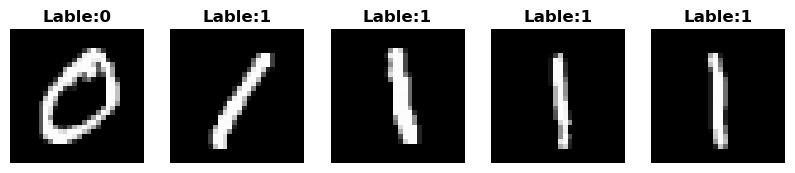

In [8]:
def show_imgs(imgs, labels):
    fig, axes = plt.subplots(1, len(imgs), figsize=(10,2))
    for img, label, ax in zip(imgs, labels, axes):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Lable:{label}')
        ax.axis("off")

    plt.show()

show_imgs(X_train[:5], y_train[:5])


### Save Data 

In [9]:
np.savez("data/mnist01_pca4.npz", 
         X_train=X_train_pca, y_train=y_train.numpy(),
         X_test=X_test_pca, y_test=y_test.numpy())     
